In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd
from pathlib import Path
import os
import time as t

import desispec
from desispec.spectra import Spectra
from desitarget.targets import desi_mask
from desispec.io import read_spectra
from astropy.io import fits
import h5py

from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.style.use('dark_background')

import logging
# logging.getLogger('desispec').setLevel(logging.WARNING)

# !rclone mount onedrive: ~/onedrive --vfs-cache-mode writes

In [2]:
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)

### Object oriented?

In [8]:
class Target:
    def __init__(self, night:int, tileid:int, spectra:Spectra):
        self.night = night
        self.tileid = tileid
        self.spectra = spectra
        self.petal = spectra.fibermap['PETAL_LOC'][0]
        self.id = spectra.fibermap['TARGETID'][0]

    def get_flux(self):
        return self.spectra.flux

    def get_wave(self):
        return self.spectra.wave

    def set_spectra(self, spectra):
        self.spectra = spectra


class Dataset:
    def __init__(self, release:str, survey:str):
        self.release = release
        self.survey = survey
        self.targets = defaultdict(dict)

    def get_target(self, targetid:int):
        return self.targets[targetid]

    def add_target(self, target:Target):
        self.targets[target.id] = target

    def remove_target(self, target:Target):
        del self.targets[target.id]

In [9]:
data_path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-0-10256-thru20211110.fits'
spectra = desispec.io.read_spectra(data_path)

mask = np.logical_and(spectra.fibermap['COADD_FIBERSTATUS']==0, spectra.fibermap['DESI_TARGET']!=0)
index = np.where(mask)[0]

tgt = np.random.choice(index)
coadd_spec = spectra[tgt]
spectra.fibermap['TARGETID'][0]

INFO:spectra.py:391:read_spectra: iotime 0.161 sec to read coadd-0-10256-thru20211110.fits at 2025-02-23T17:11:27.554927


39627539206898128

In [10]:
coadd_tgts = spectra.target_ids().data

row = (coadd_tgts == coadd_tgts[0])
coadd_spec = spectra[row]

coadd_spec.flux['b'].shape, coadd_spec.wave['r'].shape

((1, 2751), (2326,))

### Write data in csv

In [11]:
def create_csv_dataset(data_path, tiles_ids, nights, output_csv_flux, output_csv_wave):
    rows_flux, rows_wave = [], []

    for tile, night in zip(tiles_ids, nights):
        folder = os.path.join(data_path, str(tile), str(night))

        if not os.path.isdir(folder):
            print(f'Foldes {folder} does not exist\n')
            continue
        petal_files = [f for f in os.listdir(folder) if f.startswith('coadd-')]

        if not petal_files:
            print(f'No COADD file in {folder}\n')
            continue

        for petal in petal_files:
            file_path = os.path.join(folder, petal)
            try:
                sp = desispec.io.read_spectra(file_path)
            except Exception as e:
                print(f'Exception reading {file_path}: {e}\n')
                continue
            fibermap = sp.fibermap.to_pandas()
            mask = (fibermap['COADD_FIBERSTATUS'] == 0) & (fibermap['DESI_TARGET'] != 0)
            valid_indices = np.where(mask)[0]
            if valid_indices.size == 0:
                continue

            flux_b, flux_r, flux_z = sp.flux['b'], sp.flux['r'], sp.flux['z']
            flux_brz = [np.concatenate([b, r, z]) for b, r, z in zip(flux_b, flux_r, flux_z)]
            for pos in valid_indices:
                target_info = fibermap.iloc[pos]
                rows_flux.append({'TARGETID': target_info.get('TARGETID', None),
                                  'TILEID': target_info.get('TILEID', tile),
                                  'PETAL_LOC': target_info.get('PETAL_LOC', None),
                                  'FLUX_B': flux_b[pos], 'FLUX_R': flux_r[pos],
                                  'FLUX_Z': flux_z[pos], 'FLUX_BRZ': flux_brz[pos]})

            wave_b, wave_r, wave_z = sp.wave['b'], sp.wave['r'], sp.wave['z']
            wave_brz = np.concatenate([wave_b, wave_r, wave_z])
            rows_wave.append({'TILEID': tile, 'NIGHT': night,
                              'PETAL_FILE': petal, 'WAVE_B': wave_b,
                              'WAVE_R': wave_r, 'WAVE_Z': wave_z,
                              'WAVE_BRZ': wave_brz})

    df_flux, df_wave = pd.DataFrame(rows_flux), pd.DataFrame(rows_wave)
    df_flux.to_csv(output_csv_flux, index=False); df_wave.to_csv(output_csv_wave, index=False)
    print(f'Flux data saved in {output_csv_flux}'); print(f'Wave data saved in {output_csv_wave}')
    return df_flux, df_wave

In [ ]:
data_path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'
tiles_ids = os.listdir(data_path)
nights = [os.listdir(os.path.join(data_path, tiles_ids[i]))[0] for i in range(len(tiles_ids))]

output_csv_flux, output_csv_wave = './data/flux_data.csv', './data/wave_data.csv'
df_flux, df_wave = create_csv_dataset(data_path, tiles_ids, nights, output_csv_flux, output_csv_wave)

### Write data in hdf5 (better than csv for big numbers and arrays)

In [68]:
def expand_array_column(df, col, prefix):
    arrs = df[col].to_list()
    try:
        arr_stacked = np.vstack(arrs)
    except Exception as e:
        print(f"Could not stack column {col}: {e}")
        return df
    n = arr_stacked.shape[1]
    new_cols = {f'{prefix}_{i}': arr_stacked[:, i] for i in range(n)}
    new_df = pd.DataFrame(new_cols, index=df.index)
    df = df.drop(columns=[col])
    df = pd.concat([df, new_df], axis=1)
    return df

In [69]:
def create_hdf5_dataset(data_path, tiles_ids, nights, output_hdf5_flux, output_hdf5_wave):
    rows_flux, rows_wave = [], []
    for tile, night in zip(tiles_ids, nights):
        folder = os.path.join(data_path, str(tile), str(night))

        if not os.path.isdir(folder):
            print(f'Folder {folder} does not exist')
            continue

        petal_files = [f for f in os.listdir(folder) if f.startswith('coadd-')][:1]
        if not petal_files:
            print(f'No COADD file in {folder}')
            continue

        for petal in petal_files:
            file_path = os.path.join(folder, petal)
            try:
                sp = desispec.io.read_spectra(file_path)
            except Exception as e:
                print(f'Exception reading {file_path}: {e}')
                continue

            fibermap = sp.fibermap.to_pandas()
            mask = (fibermap['COADD_FIBERSTATUS'] == 0) & (fibermap['DESI_TARGET'] != 0)
            valid_indices = np.where(mask)[0]
            if valid_indices.size == 0:
                continue

            flux_b, flux_r, flux_z = sp.flux['b'], sp.flux['r'], sp.flux['z']
            flux_brz = [np.concatenate([b, r, z]) for b, r, z in zip(flux_b, flux_r, flux_z)]
            for pos in valid_indices:
                target_info = fibermap.iloc[pos]
                rows_flux.append({'TARGETID': target_info.get('TARGETID', None),
                                  'TILEID': target_info.get('TILEID', tile),
                                  'PETAL_LOC': target_info.get('PETAL_LOC', None),
                                  'FLUX_B': flux_b[pos],'FLUX_R': flux_r[pos],
                                  'FLUX_Z': flux_z[pos],'FLUX_BRZ': flux_brz[pos]})
                rows_wave.append({'TARGETID': target_info.get('TARGETID', None),
                                  'TILEID': tile,'NIGHT': night,
                                  'PETAL_FILE': petal,'WAVE_B': sp.wave['b'][pos],
                                  'WAVE_R': sp.wave['r'][pos],'WAVE_Z': sp.wave['z'][pos],
                                  'WAVE_BRZ': np.concatenate([np.atleast_1d(sp.wave['b'][pos]),
                                                            np.atleast_1d(sp.wave['r'][pos]),
                                                            np.atleast_1d(sp.wave['z'][pos])])})
    df_flux = pd.DataFrame(rows_flux)
    df_wave = pd.DataFrame(rows_wave)
    for col, prefix in [('FLUX_B', 'FLUX_B'),
                        ('FLUX_R', 'FLUX_R'),
                        ('FLUX_Z', 'FLUX_Z'),
                        ('FLUX_BRZ', 'FLUX_BRZ')]:
        df_flux = expand_array_column(df_flux, col, prefix)

    for col, prefix in [('WAVE_B', 'WAVE_B'),
                        ('WAVE_R', 'WAVE_R'),
                        ('WAVE_Z', 'WAVE_Z'),
                        ('WAVE_BRZ', 'WAVE_BRZ')]:
        df_wave = expand_array_column(df_wave, col, prefix)

    df_flux.to_hdf(output_hdf5_flux, key='df_flux', mode='w')
    print(f'Flux data saved in {output_hdf5_flux}')
    df_wave.to_hdf(output_hdf5_wave, key='df_wave', mode='w')
    print(f'Wave data saved in {output_hdf5_wave}')
    return df_flux, df_wave

In [ ]:
data_path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'
tiles_ids = os.listdir(data_path)
nights = [os.listdir(os.path.join(data_path, tiles_ids[i]))[0] for i in range(len(tiles_ids))]

output_hdf5_flux, output_hdf5_wave = './data/flux_data.h5', './data/wave_data.h5'
df_flux, df_wave = create_hdf5_dataset(data_path, tiles_ids[:1], nights[:1], output_hdf5_flux, output_hdf5_wave)

### More efficient

In [6]:
data_path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'
tiles_ids = os.listdir(data_path)
nights = [os.listdir(os.path.join(data_path, tiles_ids[i]))[0] for i in range(len(tiles_ids))]

In [3]:
def get_bitvals():
    categories = np.array(list(desi_mask.names()))
    bitvals = np.array([desi_mask[name] for name in categories])
    return categories, bitvals

def classify_targets(ids):
    categories, masks = get_bitvals()
    bool_matrix = (ids[:, None] & masks[None, :]) != 0
    types = [' '.join(categories[row]) for row in bool_matrix]
    return np.array(types)

f_file = fits.open(f'/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-0-10256-thru20211110.fits')['FIBERMAP'].data
ids = f_file['DESI_TARGET']
types = classify_targets(ids)

ids.shape, types.shape

((500,), (500,))

In [7]:
data_path = '/Users/valeriatorresgomez/onedrive/tiny_dr1/spectro/redux/iron/tiles/cumulative'
tiles_id = os.listdir(data_path)
nights = [os.listdir(os.path.join(data_path, tiles_id[i]))[0] for i in range(len(tiles_id))]

with h5py.File("./data/sample.h5", "w") as f:
    for i, night in enumerate(nights):
        tile_dir = os.path.join(data_path, tiles_id[i], night)
        tiles = [fname for fname in os.listdir(tile_dir) if fname.startswith('coadd-')]

        night_group = f.create_group(night)
        tile_group = night_group.create_group(tiles_id[i])

        for j, petal in enumerate(tiles[:2]):

            petal_group = tile_group.create_group(petal.split('-')[1])
            petal_path = os.path.join(data_path, tiles_id[i], night, petal)

            coadd_obj = desispec.io.read_spectra(petal_path)
            fits_file = fits.open(petal_path)['FIBERMAP'].data

            mask = np.logical_and(fits_file['COADD_FIBERSTATUS'] == 0, fits_file['DESI_TARGET'] != 0)
            coadd_spec, fits_filtered = coadd_obj[mask], fits_file[mask]

            target_ids = fits_filtered['TARGETID']
            petal_group.create_dataset("target_id", data=target_ids, compression="gzip")
            types = classify_targets(target_ids)

            str_dt = h5py.string_dtype(encoding='utf-8')
            types_array = np.array(types, dtype=str_dt)
            petal_group.create_dataset("target_type", data=types_array, dtype=str_dt, compression="gzip")

            fluxes, waves = coadd_spec.flux, coadd_spec.wave
            flux_group, wave_group = petal_group.create_group('flux'), petal_group.create_group('wave')

            for band in ['b', 'r', 'z']:
                flux_group.create_dataset(band, data=fluxes[band], compression='gzip')
                wave_group.create_dataset(band, data=waves[band], compression='gzip')

            wave_brz = np.concatenate([coadd_spec.wave['b'], coadd_spec.wave['r'], coadd_spec.wave['z']])
            flux_brz = np.concatenate([coadd_spec.flux['b'], coadd_spec.flux['r'], coadd_spec.flux['z']], axis=1)
            flux_group.create_dataset('brz', data=flux_brz, compression='gzip')
            wave_group.create_dataset('brz', data=wave_brz, compression='gzip')

INFO:spectra.py:391:read_spectra: iotime 0.267 sec to read coadd-0-10256-thru20211110.fits at 2025-02-23T17:06:57.793186
INFO:spectra.py:391:read_spectra: iotime 47.770 sec to read coadd-1-10256-thru20211110.fits at 2025-02-23T17:07:47.015320
INFO:spectra.py:391:read_spectra: iotime 4.718 sec to read coadd-0-2436-thru20211031.fits at 2025-02-23T17:07:53.875409
INFO:spectra.py:391:read_spectra: iotime 44.377 sec to read coadd-1-2436-thru20211031.fits at 2025-02-23T17:08:39.591253
INFO:spectra.py:391:read_spectra: iotime 45.020 sec to read coadd-0-5568-thru20211130.fits at 2025-02-23T17:09:26.089971
INFO:spectra.py:391:read_spectra: iotime 111.014 sec to read coadd-1-5568-thru20211130.fits at 2025-02-23T17:11:18.964245


In [19]:
with h5py.File("sample.h5", "r") as f:
    # print(f.keys())
    # print(f['20211110'].keys())
    # print(f['20211110']['10256'].keys())
    petal = f['20211110']['10256']['0']

    print(f'groups: {list(petal.keys())}')
    target_ids = petal['target_id'][:]

    flux_b = petal['flux']['b'][:]
    print(f'target_id: {target_ids[0]}\n')
    print(f"b: {f['20211110']['10256']['0']['flux']['b'][:].shape}")
    print(f"r: {f['20211110']['10256']['0']['flux']['r'][:].shape}")
    print(f"z: {f['20211110']['10256']['0']['flux']['z'][:].shape}")
    print(f"brz: {f['20211110']['10256']['0']['flux']['brz'][:].shape}\n")

    print(f"b: {f['20211110']['10256']['0']['wave']['b'][:].shape}")
    print(f"r: {f['20211110']['10256']['0']['wave']['r'][:].shape}")
    print(f"z: {f['20211110']['10256']['0']['wave']['z'][:].shape}")
    print(f"brz: {f['20211110']['10256']['0']['wave']['brz'][:].shape}")

groups: ['flux', 'target_id', 'target_type', 'wave']
target_id: 39627539206898128

b: (453, 2751)
r: (453, 2326)
z: (453, 2881)
brz: (453, 7958)

b: (2751,)
r: (2326,)
z: (2881,)
brz: (7958,)


### Time complex

In [168]:
df = pd.read_csv('./scripts/logs/log.csv')
df.tail()

,tile,night,petal,n_targets,time
24,5568,20211130,5,423,47.387768
25,5568,20211130,6,436,48.647116
26,5568,20211130,7,380,54.343832
27,5568,20211130,8,430,47.915137
28,5568,20211130,9,442,44.918030


In [169]:
df['time'].mean()/60

0.7507760142457897

In [170]:
df.sort_values('time', ascending=True).head()

,tile,night,petal,n_targets,time
20,5568,20211130,1,408,1.612146
0,10256,20211110,0,453,1.697360
10,2436,20211031,0,453,44.602942
28,5568,20211130,9,442,44.918030
11,2436,20211031,1,402,45.169678


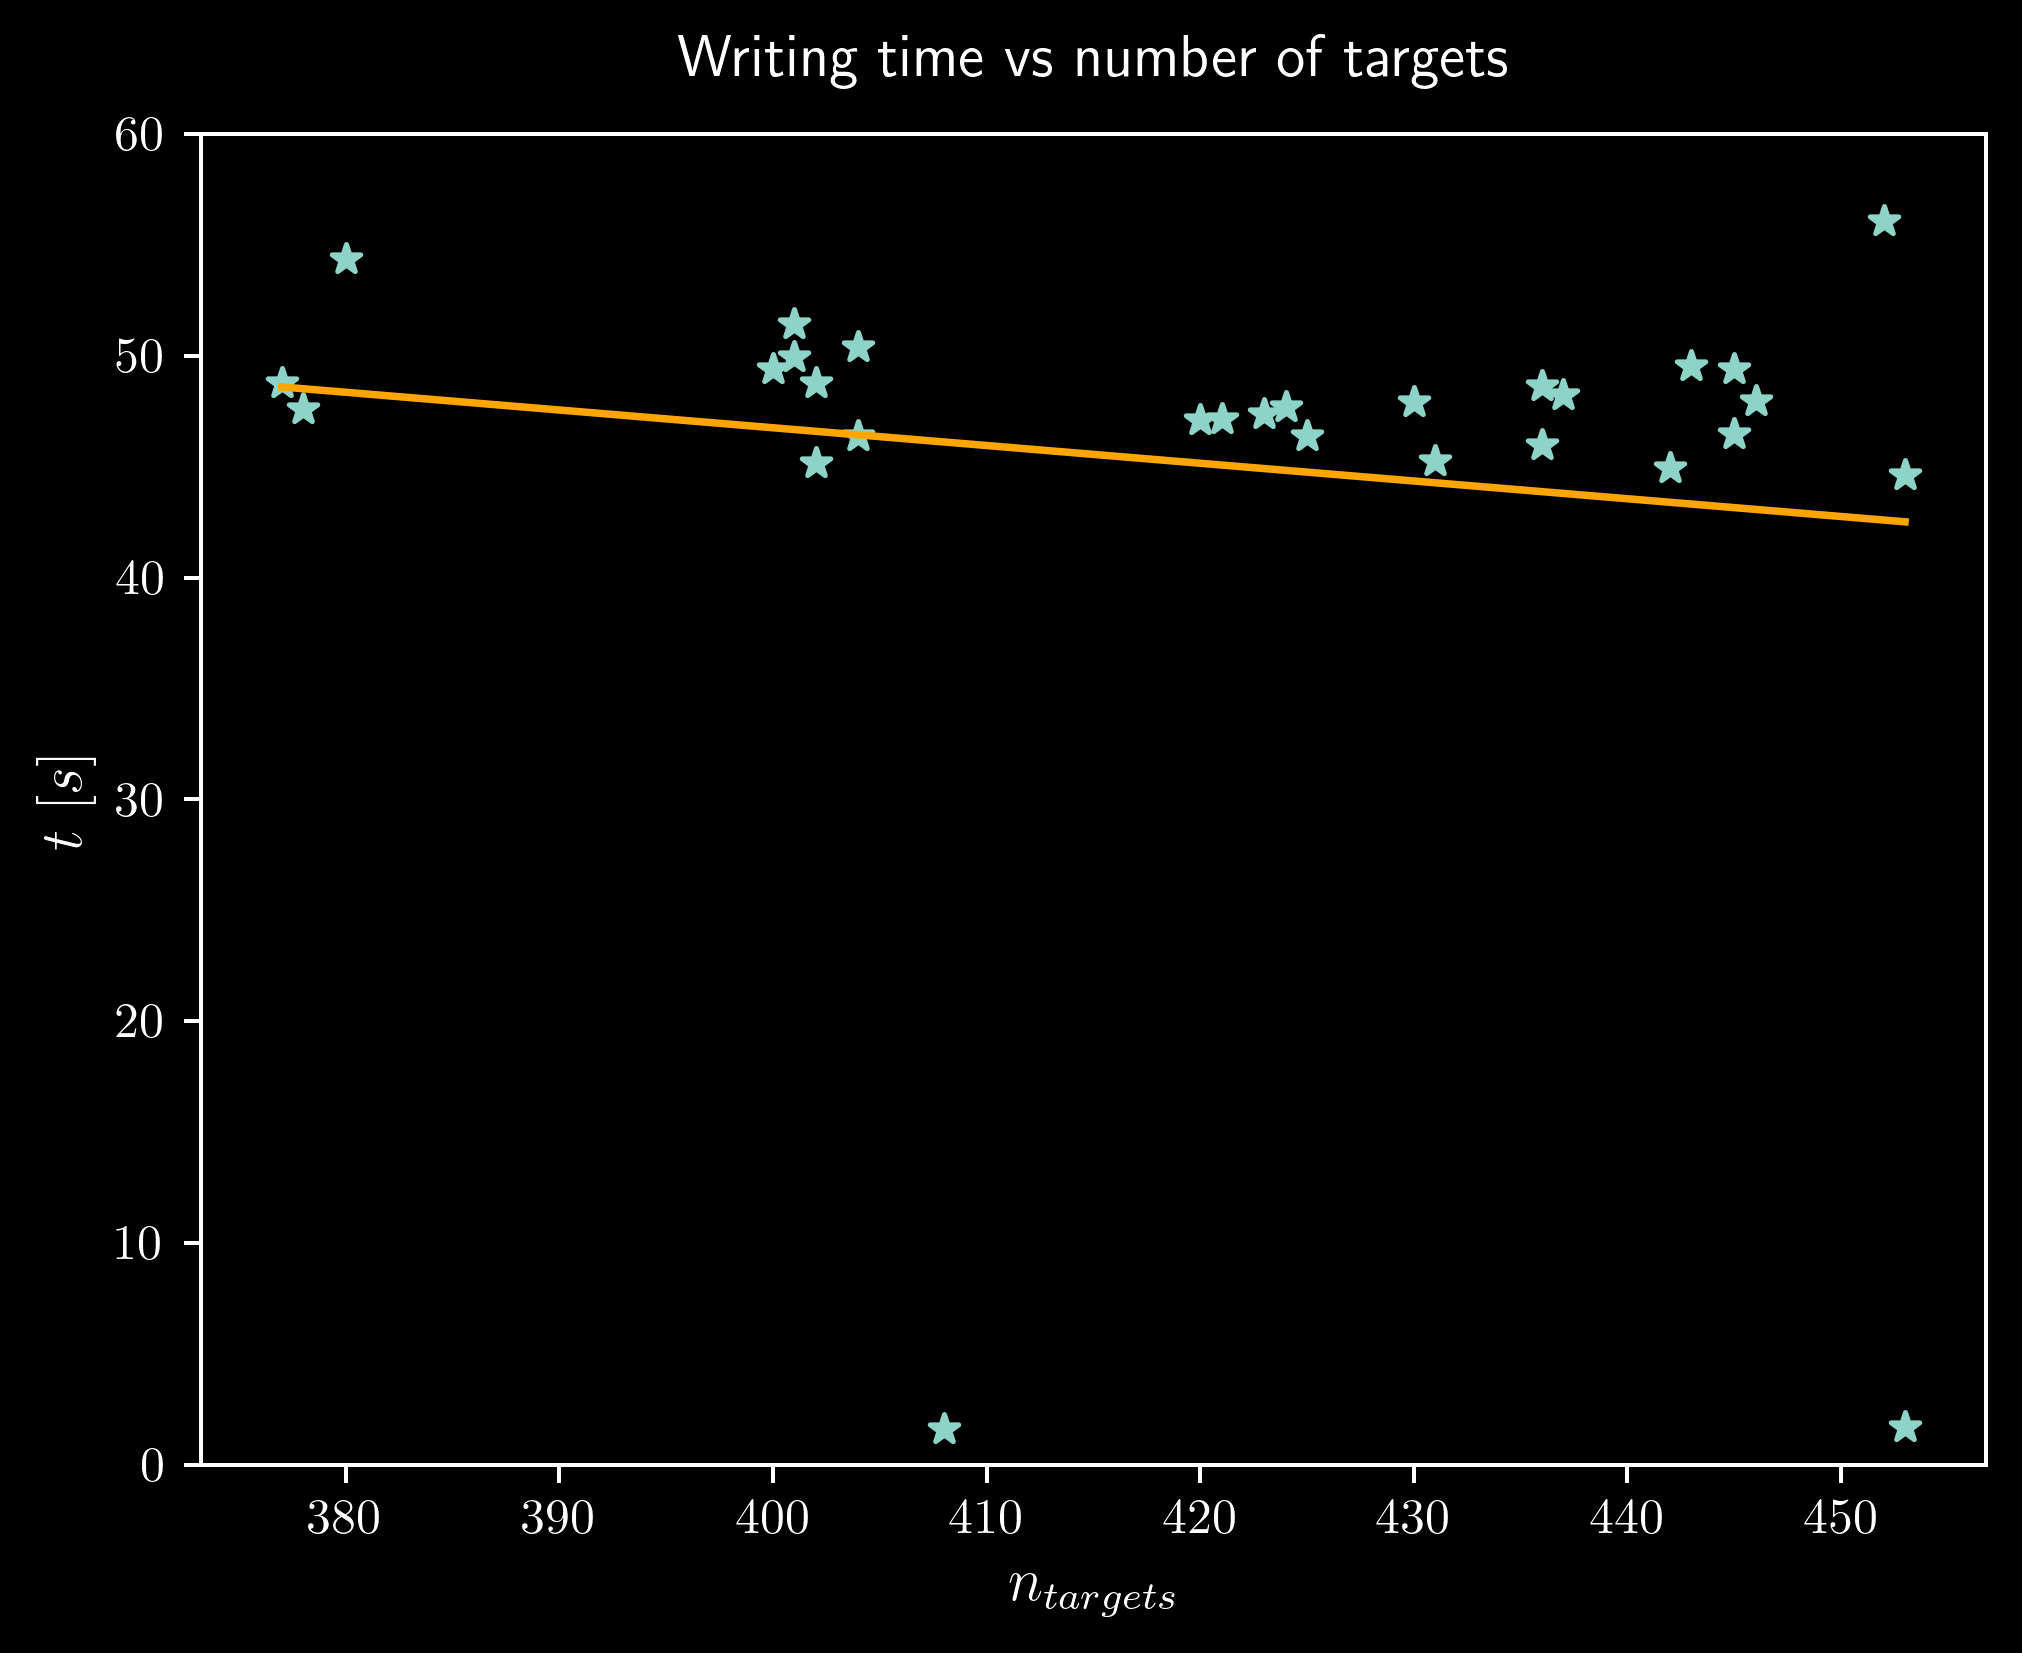

In [171]:
x = np.argsort(df['n_targets'])
m, b, _, _, _ = linregress(df['n_targets'], df['time'])

plt.scatter(df['n_targets'][x], df['time'][x], ls='-', marker='*')
plt.plot(df['n_targets'][x], df['n_targets'][x]*m+b, c='orange')

plt.xlabel(r'$n_{targets}$', fontsize=12); plt.ylabel('$t$ $[s]$', fontsize=12)
plt.title('Writing time vs number of targets', y=1.02)
# plt.yscale('log')
plt.ylim(0,60)
plt.show()